In [1]:
building_id = 2
price = 100
iteration = 0
# we are ready to run!

In [2]:
# Parameters
building_id = 0
price = 106
iteration = 5


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
error_dir  = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(output_dir)

# EHUB
ehub_dir   = 'ehub/output_ehub_excel/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106
ga_file = ga_output_dir + "panel_{}_dual.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_dual_processed.xlsx".format(price)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Large Office New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep()

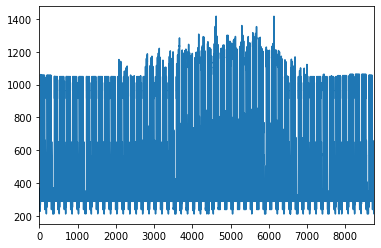

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 178,523.31
1152.5679573158798


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 3,563 m²
Roof area is up 49 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.595016241073608 sec


0.0


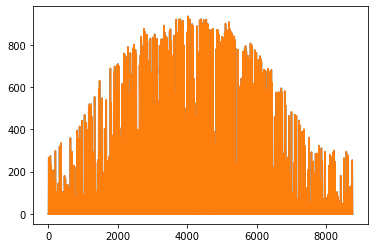

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)
Loading the model
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


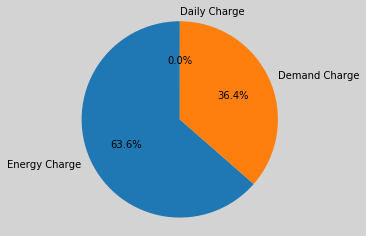

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%


In [16]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [35,55,10,35,5]
    gcr = [0.6,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [35,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)

pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)
my_model.eval_model(pan_vals,400,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.energyIm

5141400.0

In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    178523.4
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr        395147.0
Aug        514587.0
Dec        402070.0
Feb        367362.0
Jan        408575.0
Jul        478270.0
Jun        463664.0
Mar        424326.0
May        438232.0
Nov        398329.0
Oct        413882.0
Sep        436953.0
monthly_import    5141397.0
dtype: float64
5141400.0
     monthly_export
Apr             0.0
Aug             0.0
Dec             0.0
Feb             0.0
Jan             0.0
Jul             0.0
Jun             0.0
Mar             0.0
May             0.0
Nov             0.0
Oct             0.0
Sep             0.0
monthly_export    0.0
dtype: float64
0.0
97.5645


In [20]:
my_model.solveResults['solution']['daily_charge_c']

97.5645

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             0
PV0                  0
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

1

In [23]:
my_model.solveResults['solution']['a150_or_a550']

1

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 220, 245, 16, 51, 46, 0.6499999999999999, 0.35, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 16.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.134609460830688 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.93474268913269 sec


ERROR:ga_logger:Generated the panel irradiance in  17s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [182.693, 442.307, 0.0]


ERROR:ga_logger:Cost: 484547.0


ERROR:ga_logger:total demand cost: 173781.00000000003


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,026,560 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,547 per year


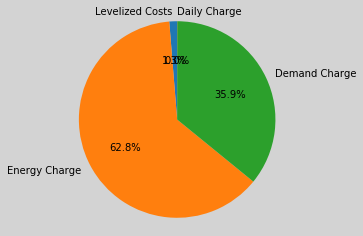

Total roof area of the  building: 3,563 m²
Total roof area used 1,545 m²
Percentage: 43.4%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (195, 245, 115, 31, 21, 51, 0.39999999999999997, 0.5999999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483445.0


ERROR:ga_logger:total demand cost: 173513.5


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,013,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,445 per year


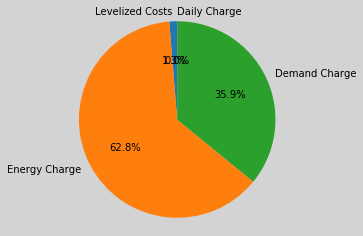

Total roof area of the  building: 3,563 m²
Total roof area used 1,562 m²
Percentage: 43.9%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (110, 115, 140, 41, 21, 51, 0.39999999999999997, 0.8499999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.201822280883789 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.314483165740967 sec


ERROR:ga_logger:Generated the panel irradiance in  15s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 547.502, 77.4976]


ERROR:ga_logger:Cost: 486211.0


ERROR:ga_logger:total demand cost: 175084.5


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,033,960 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 486,211 per year


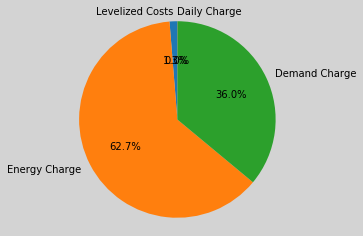

Total roof area of the  building: 3,563 m²
Total roof area used 866 m²
Percentage: 24.3%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (200, 245, 250, 26, 36, 26, 0.7999999999999998, 0.5499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 26.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.01778507232666 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.689502000808716 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in  17s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 484193.0


ERROR:ga_logger:total demand cost: 173731.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,021,860 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,193 per year


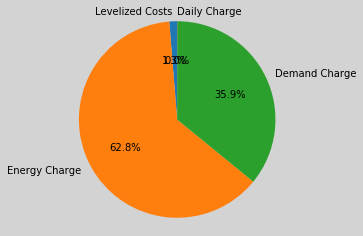

Total roof area of the  building: 3,563 m²
Total roof area used 781 m²
Percentage: 21.9%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (195, 145, 180, 6, 46, 11, 0.5499999999999999, 0.5499999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 6.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.332744598388672 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 11.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.23694920539856 sec


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484054.0


ERROR:ga_logger:total demand cost: 173740.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,021,020 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 484,054 per year


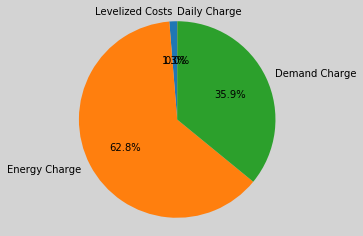

Total roof area of the  building: 3,563 m²
Total roof area used 1,786 m²
Percentage: 50.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (190, 105, 180, 46, 31, 11, 0.7999999999999998, 0.8999999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.022503137588501 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.460842132568359 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 11.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in  14s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484050.0


ERROR:ga_logger:total demand cost: 173739.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,019,620 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,050 per year


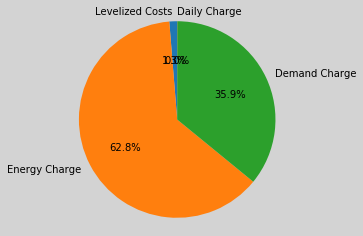

Total roof area of the  building: 3,563 m²
Total roof area used 2,083 m²
Percentage: 58.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (255, 140, 250, 36, 26, 6, 0.7999999999999998, 0.5999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 6.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.047579765319824 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 63.4065, 561.593]


ERROR:ga_logger:Cost: 484571.0


ERROR:ga_logger:total demand cost: 173787.90000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,027,160 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,571 per year


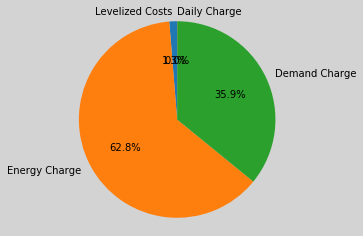

Total roof area of the  building: 3,563 m²
Total roof area used 1,229 m²
Percentage: 34.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (250, 120, 135, 56, 51, 51, 0.8499999999999999, 0.3, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.19454288482666 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [379.669, 0.0, 245.331]


ERROR:ga_logger:Cost: 486254.0


ERROR:ga_logger:total demand cost: 174300.90000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,048,790 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 486,254 per year


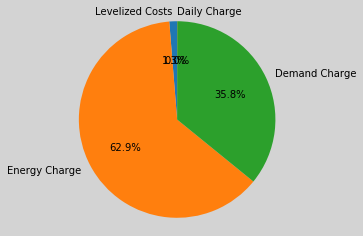

Total roof area of the  building: 3,563 m²
Total roof area used 1,264 m²
Percentage: 35.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 120, 115, 26, 21, 21, 0.5999999999999999, 0.6499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.110213756561279 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 485607.0


ERROR:ga_logger:total demand cost: 174867.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,028,000 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 485,607 per year


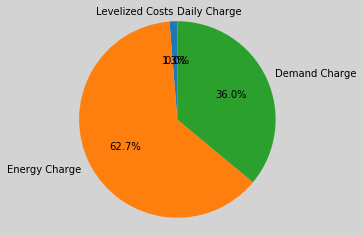

Total roof area of the  building: 3,563 m²
Total roof area used 962 m²
Percentage: 27.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (210, 220, 140, 36, 41, 51, 0.7499999999999998, 0.7499999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [548.703, 0.0, 76.2972]


ERROR:ga_logger:Cost: 484555.0


ERROR:ga_logger:total demand cost: 173874.19999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,025,920 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,555 per year


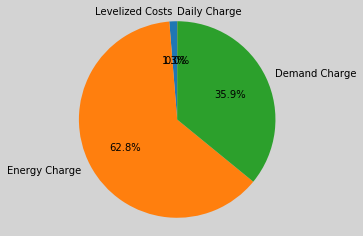

Total roof area of the  building: 3,563 m²
Total roof area used 922 m²
Percentage: 25.9%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (235, 240, 175, 36, 21, 31, 0.25, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 36.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.493503093719482 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 145, 120, 16, 26, 36, 0.3, 0.39999999999999997, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 26.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.201316833496094 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.37213134765625 sec


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [377.888, 247.112, 0.0]


ERROR:ga_logger:Cost: 484149.0


ERROR:ga_logger:total demand cost: 173678.6


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,022,330 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,149 per year


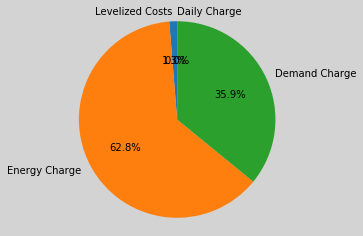

Total roof area of the  building: 3,563 m²
Total roof area used 1,877 m²
Percentage: 52.7%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (230, 150, 145, 41, 11, 16, 0.44999999999999996, 0.3, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [189.375, 435.625, 0.0]


ERROR:ga_logger:Cost: 484130.0


ERROR:ga_logger:total demand cost: 173650.19999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,022,520 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,130 per year


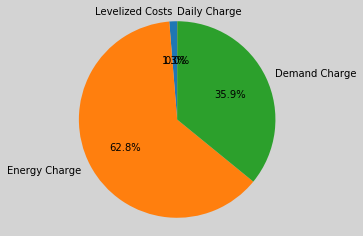

Total roof area of the  building: 3,563 m²
Total roof area used 1,873 m²
Percentage: 52.6%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (120, 120, 190, 36, 31, 11, 0.8499999999999999, 0.7, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.842895984649658 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484023.0


ERROR:ga_logger:total demand cost: 173656.80000000005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,023,650 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 484,023 per year


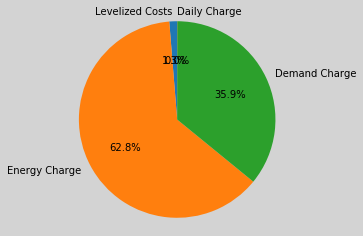

Total roof area of the  building: 3,563 m²
Total roof area used 962 m²
Percentage: 27.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 160, 260, 6, 31, 41, 0.5999999999999999, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 6.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.292531728744507 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484180.0


ERROR:ga_logger:total demand cost: 174136.69999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,015,710 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,180 per year


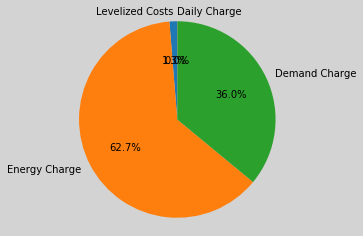

Total roof area of the  building: 3,563 m²
Total roof area used 1,250 m²
Percentage: 35.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 190, 105, 41, 16, 31, 0.3, 0.39999999999999997, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 41.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.831035375595093 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.739894151687622 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483682.0


ERROR:ga_logger:total demand cost: 173534.7


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,017,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,682 per year


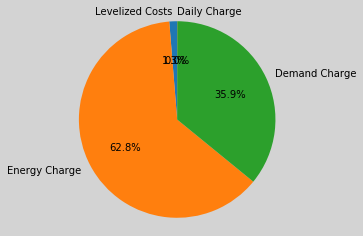

Total roof area of the  building: 3,563 m²
Total roof area used 1,562 m²
Percentage: 43.9%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (145, 110, 160, 21, 31, 46, 0.6499999999999999, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.923181533813477 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 484689.0


ERROR:ga_logger:total demand cost: 174330.8


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,020,680 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,689 per year


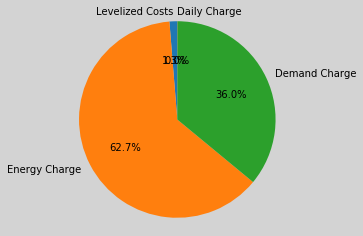

Total roof area of the  building: 3,563 m²
Total roof area used 962 m²
Percentage: 27.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (145, 215, 250, 31, 21, 21, 0.6499999999999999, 0.6499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.646329402923584 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.618552207946777 sec


ERROR:ga_logger:Generated the panel irradiance in  14s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483981.0


ERROR:ga_logger:total demand cost: 173589.09999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,020,970 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,981 per year


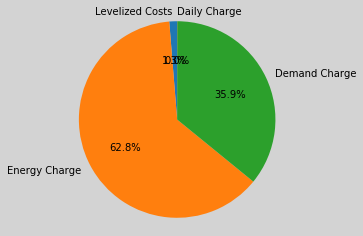

Total roof area of the  building: 3,563 m²
Total roof area used 962 m²
Percentage: 27.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (135, 245, 245, 41, 6, 56, 0.49999999999999994, 0.44999999999999996, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484557.0


ERROR:ga_logger:total demand cost: 173760.6


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,028,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,557 per year


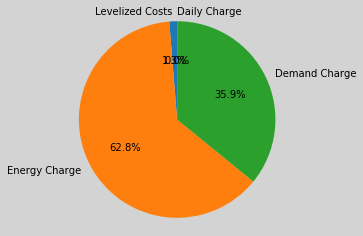

Total roof area of the  building: 3,563 m²
Total roof area used 1,389 m²
Percentage: 39.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (145, 220, 255, 51, 6, 26, 0.6499999999999999, 0.8999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484507.0


ERROR:ga_logger:total demand cost: 173743.40000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,027,700 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,507 per year


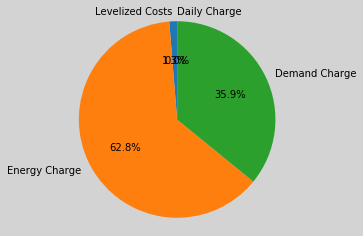

ERROR:optimizer_logger:20


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 3,563 m²
Total roof area used 694 m²
Percentage: 19.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (215, 190, 145, 36, 1, 36, 0.7, 0.6499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 36.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.820644378662109 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [462.337, 0.0, 162.663]


ERROR:ga_logger:Cost: 484434.0


ERROR:ga_logger:total demand cost: 173811.19999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,024,580 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,434 per year


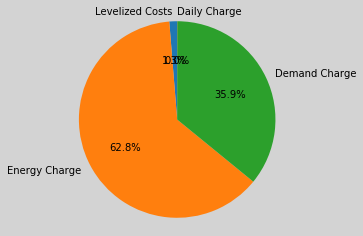

Total roof area of the  building: 3,563 m²
Total roof area used 932 m²
Percentage: 26.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (225, 105, 235, 51, 36, 6, 0.7, 0.6499999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 36.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484475.0


ERROR:ga_logger:total demand cost: 173739.30000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,026,580 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,475 per year


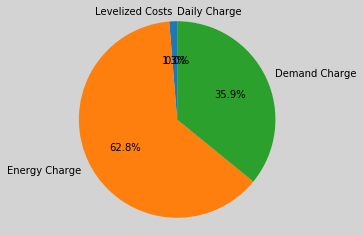

Total roof area of the  building: 3,563 m²
Total roof area used 2,083 m²
Percentage: 58.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (155, 160, 115, 16, 16, 46, 0.6499999999999999, 0.7, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.229418754577637 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484291.0


ERROR:ga_logger:total demand cost: 173977.1


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,020,850 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 484,291 per year


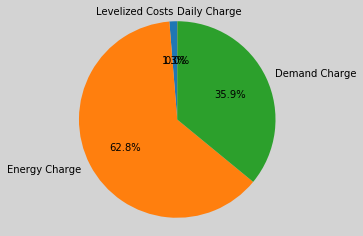

Total roof area of the  building: 3,563 m²
Total roof area used 893 m²
Percentage: 25.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 185, 145, 1, 36, 46, 0.7, 0.35, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483385.0


ERROR:ga_logger:total demand cost: 173536.0


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,011,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,385 per year


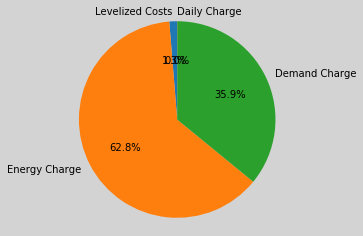

Total roof area of the  building: 3,563 m²
Total roof area used 1,786 m²
Percentage: 50.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (90, 240, 195, 6, 36, 36, 0.39999999999999997, 0.7, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 6.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.984255790710449 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.9211766719818115 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484673.0


ERROR:ga_logger:total demand cost: 174035.6


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,025,480 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,673 per year


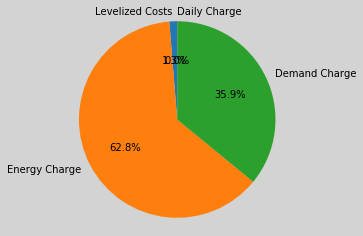

Total roof area of the  building: 3,563 m²
Total roof area used 735 m²
Percentage: 20.6%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (120, 175, 165, 1, 11, 36, 0.35, 0.8999999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 1.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.070924520492554 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484421.0


ERROR:ga_logger:total demand cost: 173828.8


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,024,960 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,421 per year


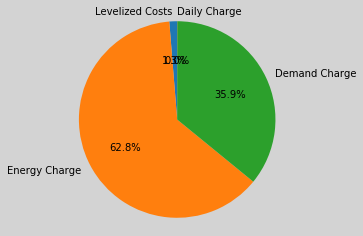

Total roof area of the  building: 3,563 m²
Total roof area used 694 m²
Percentage: 19.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (185, 210, 240, 46, 6, 11, 0.35, 0.3, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 46.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.996523857116699 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483692.0


ERROR:ga_logger:total demand cost: 173690.20000000004


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,014,480 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,692 per year


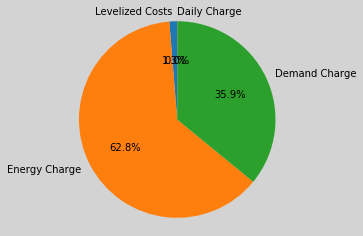

Total roof area of the  building: 3,563 m²
Total roof area used 1,786 m²
Percentage: 50.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (145, 110, 160, 46, 1, 6, 0.7, 0.2, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484684.0


ERROR:ga_logger:total demand cost: 173998.10000000003


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,027,110 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 484,684 per year


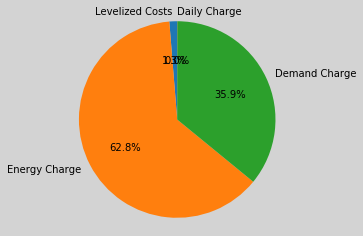

Total roof area of the  building: 3,563 m²
Total roof area used 694 m²
Percentage: 19.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (255, 245, 225, 36, 26, 36, 0.8999999999999999, 0.39999999999999997, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484563.0


ERROR:ga_logger:total demand cost: 173799.0


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,027,440 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,563 per year


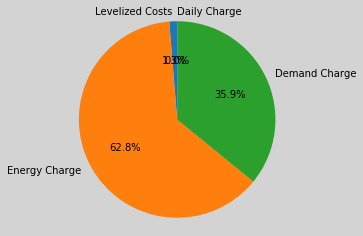

Total roof area of the  building: 3,563 m²
Total roof area used 1,562 m²
Percentage: 43.9%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (265, 255, 255, 1, 6, 51, 0.2, 0.7499999999999998, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.832375764846802 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484664.0


ERROR:ga_logger:total demand cost: 173787.3


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,029,600 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,664 per year


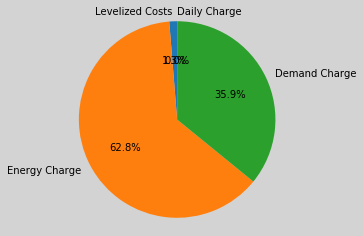

Total roof area of the  building: 3,563 m²
Total roof area used 833 m²
Percentage: 23.4%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (155, 160, 100, 51, 1, 36, 0.2, 0.5999999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 1.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.855333566665649 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 36.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.249150991439819 sec


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484883.0


ERROR:ga_logger:total demand cost: 174036.30000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,029,960 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 484,883 per year


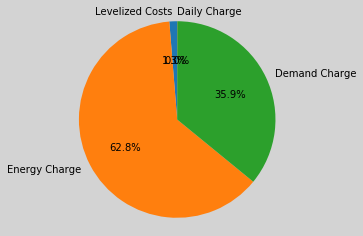

Total roof area of the  building: 3,563 m²
Total roof area used 1,042 m²
Percentage: 29.2%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (125, 110, 215, 46, 31, 21, 0.35, 0.3, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 483758.0


ERROR:ga_logger:total demand cost: 173551.7


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,018,150 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,758 per year


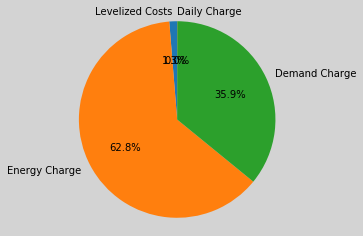

Total roof area of the  building: 3,563 m²
Total roof area used 2,500 m²
Percentage: 70.2%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (260, 175, 170, 46, 41, 51, 0.35, 0.8999999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.391888380050659 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.211373567581177 sec


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484232.0


ERROR:ga_logger:total demand cost: 174177.90000000005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,015,780 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,232 per year


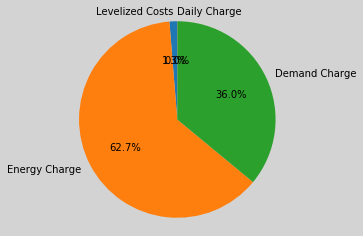

Total roof area of the  building: 3,563 m²
Total roof area used 3,125 m²
Percentage: 87.7%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (145, 245, 90, 51, 36, 1, 0.49999999999999994, 0.7, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 150.637, 474.363]


ERROR:ga_logger:Cost: 484863.0


ERROR:ga_logger:total demand cost: 173831.6


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,031,850 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,863 per year


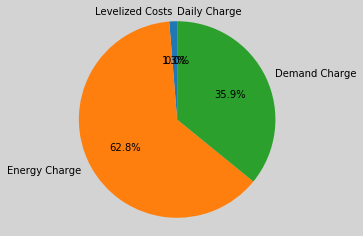

Total roof area of the  building: 3,563 m²
Total roof area used 1,269 m²
Percentage: 35.6%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (150, 210, 165, 1, 16, 11, 0.8999999999999999, 0.7999999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 11.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.995832681655884 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 341.573, 283.427]


ERROR:ga_logger:Cost: 484067.0


ERROR:ga_logger:total demand cost: 173626.6


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,022,500 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,067 per year


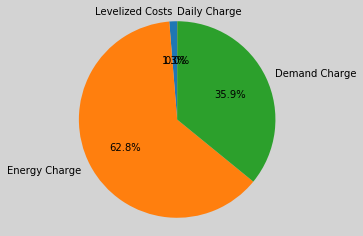

Total roof area of the  building: 3,563 m²
Total roof area used 1,057 m²
Percentage: 29.7%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (105, 145, 220, 46, 6, 56, 0.3, 0.49999999999999994, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 46.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.433135509490967 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 6.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.345911502838135 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484684.0


ERROR:ga_logger:total demand cost: 174078.6


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,024,550 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,684 per year


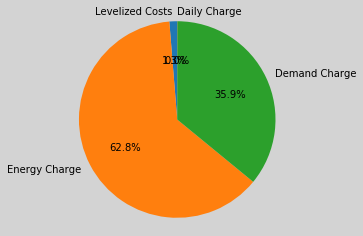

Total roof area of the  building: 3,563 m²
Total roof area used 1,250 m²
Percentage: 35.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (265, 220, 110, 51, 1, 16, 0.2, 0.49999999999999994, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 51.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 16.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.388701915740967 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [65.979, 559.021, 0.0]


ERROR:ga_logger:Cost: 484829.0


ERROR:ga_logger:total demand cost: 173853.80000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,030,630 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,829 per year


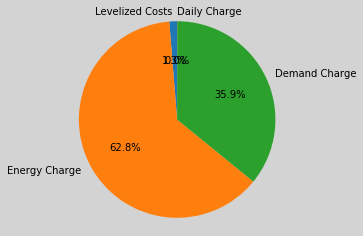

Total roof area of the  building: 3,563 m²
Total roof area used 1,448 m²
Percentage: 40.6%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (215, 140, 230, 56, 51, 51, 0.8999999999999999, 0.35, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 169.093, 455.907]


ERROR:ga_logger:Cost: 484608.0


ERROR:ga_logger:total demand cost: 173776.7


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,028,330 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,608 per year


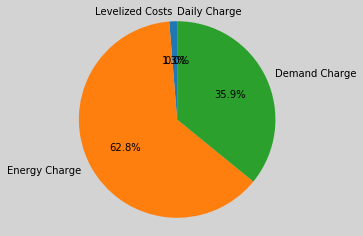

Total roof area of the  building: 3,563 m²
Total roof area used 1,786 m²
Percentage: 50.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (165, 265, 175, 6, 1, 1, 0.7499999999999998, 0.35, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 484548.0


ERROR:ga_logger:total demand cost: 173957.49999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,024,970 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,548 per year


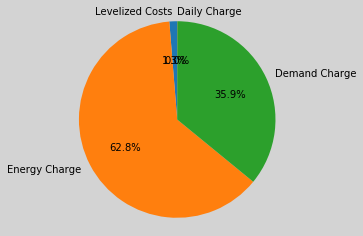

Total roof area of the  building: 3,563 m²
Total roof area used 833 m²
Percentage: 23.4%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (115, 240, 180, 46, 6, 11, 0.7999999999999998, 0.8499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 46.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.056502819061279 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 11.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.3419482707977295 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484383.0


ERROR:ga_logger:total demand cost: 173796.7


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,025,520 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 484,383 per year


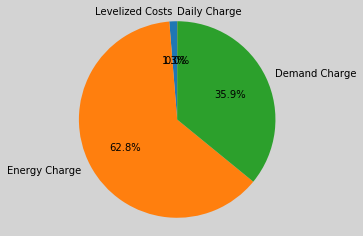

ERROR:optimizer_logger:40


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 3,563 m²
Total roof area used 694 m²
Percentage: 19.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (225, 200, 235, 51, 1, 6, 0.8499999999999999, 0.5499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.555964708328247 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.584275960922241 sec


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484502.0


ERROR:ga_logger:total demand cost: 173744.39999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,026,990 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,502 per year


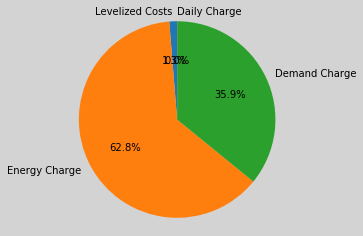

Total roof area of the  building: 3,563 m²
Total roof area used 833 m²
Percentage: 23.4%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (200, 250, 100, 21, 26, 1, 0.8499999999999999, 0.5999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 1.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.199239492416382 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 484327.0


ERROR:ga_logger:total demand cost: 173790.1


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,022,840 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,327 per year


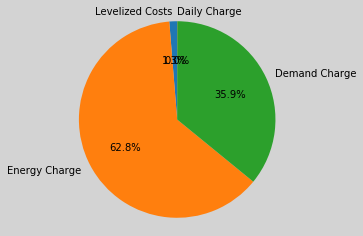

Total roof area of the  building: 3,563 m²
Total roof area used 735 m²
Percentage: 20.6%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (260, 135, 115, 36, 36, 41, 0.7, 0.3, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.294792175292969 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [316.574, 308.426, 0.0]


ERROR:ga_logger:Cost: 485034.0


ERROR:ga_logger:total demand cost: 173945.79999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,032,360 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 485,034 per year


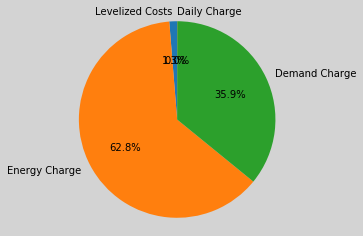

Total roof area of the  building: 3,563 m²
Total roof area used 1,480 m²
Percentage: 41.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (185, 145, 205, 56, 6, 11, 0.7, 0.5999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 56.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  93s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 18.3584, 606.642]


ERROR:ga_logger:Cost: 484433.0


ERROR:ga_logger:total demand cost: 173766.50000000003


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,025,310 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,433 per year


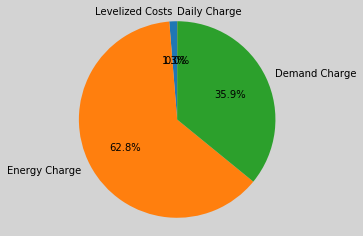

Total roof area of the  building: 3,563 m²
Total roof area used 705 m²
Percentage: 19.8%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (225, 135, 175, 46, 31, 51, 0.5999999999999999, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [324.981, 300.019, 0.0]


ERROR:ga_logger:Cost: 484495.0


ERROR:ga_logger:total demand cost: 173768.10000000003


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,026,590 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,495 per year


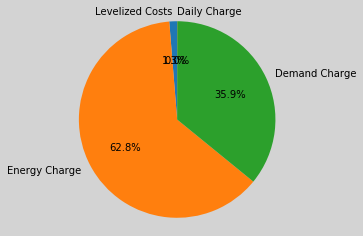

Total roof area of the  building: 3,563 m²
Total roof area used 1,142 m²
Percentage: 32.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 170, 250, 36, 16, 51, 0.5499999999999999, 0.3, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  93s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [107.792, 517.208, 0.0]


ERROR:ga_logger:Cost: 483879.0


ERROR:ga_logger:total demand cost: 173584.60000000003


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,019,720 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,879 per year


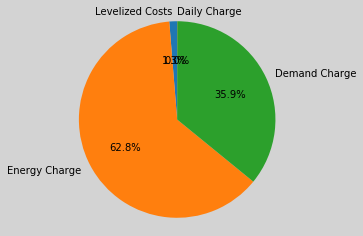

Total roof area of the  building: 3,563 m²
Total roof area used 1,920 m²
Percentage: 53.9%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 215, 250, 31, 46, 56, 0.5499999999999999, 0.2, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 31.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.25923490524292 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0852179527282715 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  93s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484064.0


ERROR:ga_logger:total demand cost: 173774.19999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,018,110 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,064 per year


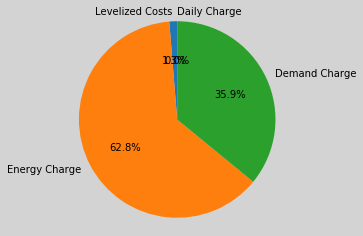

Total roof area of the  building: 3,563 m²
Total roof area used 3,125 m²
Percentage: 87.7%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (125, 95, 230, 21, 26, 26, 0.8499999999999999, 0.5499999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.528505325317383 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484087.0


ERROR:ga_logger:total demand cost: 173698.6


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,020,090 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,087 per year


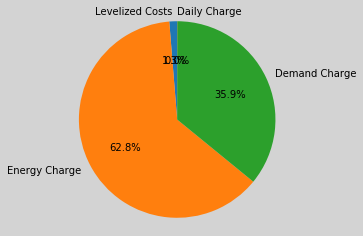

Total roof area of the  building: 3,563 m²
Total roof area used 3,125 m²
Percentage: 87.7%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (185, 205, 180, 1, 46, 16, 0.3, 0.7999999999999998, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.449992895126343 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 16.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.6583030223846436 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484217.0


ERROR:ga_logger:total demand cost: 173770.59999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,022,480 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,217 per year


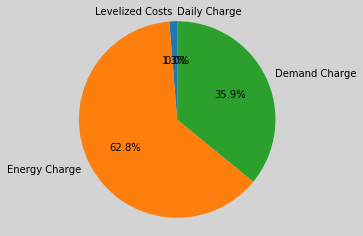

Total roof area of the  building: 3,563 m²
Total roof area used 735 m²
Percentage: 20.6%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (145, 225, 125, 41, 16, 31, 0.7999999999999998, 0.44999999999999996, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484069.0


ERROR:ga_logger:total demand cost: 173621.5


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,021,690 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,069 per year


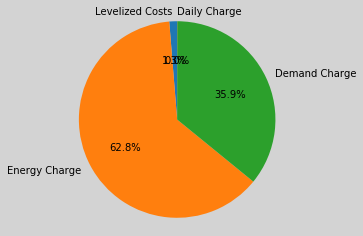

Total roof area of the  building: 3,563 m²
Total roof area used 1,389 m²
Percentage: 39.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (115, 200, 245, 46, 41, 56, 0.5499999999999999, 0.49999999999999994, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 46.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.6277477741241455 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483902.0


ERROR:ga_logger:total demand cost: 173711.80000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,016,990 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,902 per year


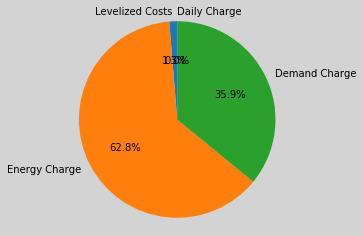

Total roof area of the  building: 3,563 m²
Total roof area used 1,250 m²
Percentage: 35.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (220, 220, 215, 11, 46, 36, 0.5499999999999999, 0.7499999999999998, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.558911085128784 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 46.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.242013692855835 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.215190410614014 sec


ERROR:ga_logger:Generated the panel irradiance in  14s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  93s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 483833.0


ERROR:ga_logger:total demand cost: 173687.0


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,016,850 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,833 per year


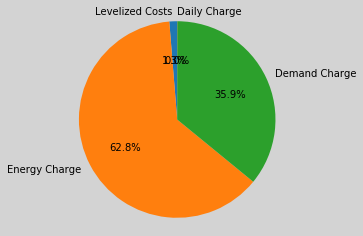

Total roof area of the  building: 3,563 m²
Total roof area used 2,500 m²
Percentage: 70.2%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (190, 245, 105, 21, 56, 31, 0.2, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483464.0


ERROR:ga_logger:total demand cost: 173483.90000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,013,340 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,464 per year


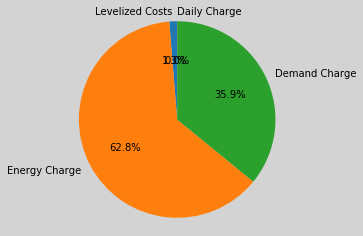

Total roof area of the  building: 3,563 m²
Total roof area used 3,125 m²
Percentage: 87.7%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (240, 125, 245, 31, 1, 56, 0.7999999999999998, 0.5999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 31.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  93s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [114.46, 510.54, 0.0]


ERROR:ga_logger:Cost: 484856.0


ERROR:ga_logger:total demand cost: 173899.30000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,031,220 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,856 per year


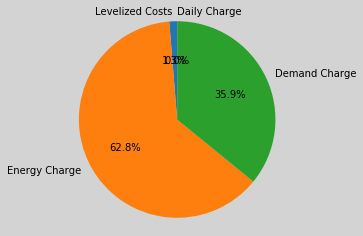

Total roof area of the  building: 3,563 m²
Total roof area used 994 m²
Percentage: 27.9%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (175, 135, 100, 26, 21, 11, 0.3, 0.6499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 21.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.801581382751465 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.674134731292725 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483519.0


ERROR:ga_logger:total demand cost: 173653.50000000003


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,012,300 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,519 per year


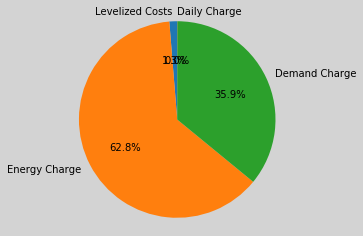

Total roof area of the  building: 3,563 m²
Total roof area used 2,083 m²
Percentage: 58.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 260, 230, 46, 1, 26, 0.6499999999999999, 0.35, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 507.23, 117.77]


ERROR:ga_logger:Cost: 484884.0


ERROR:ga_logger:total demand cost: 173921.19999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,031,480 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,884 per year


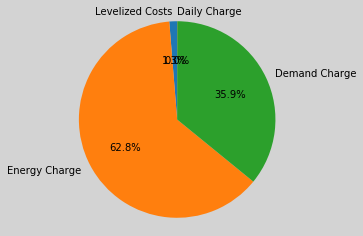

Total roof area of the  building: 3,563 m²
Total roof area used 1,580 m²
Percentage: 44.3%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (205, 165, 135, 26, 31, 26, 0.3, 0.5999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483549.0


ERROR:ga_logger:total demand cost: 173524.9


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,017,940 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 483,549 per year


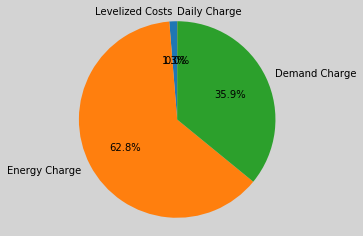

Total roof area of the  building: 3,563 m²
Total roof area used 2,083 m²
Percentage: 58.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 230, 260, 46, 26, 1, 0.5499999999999999, 0.5499999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484299.0


ERROR:ga_logger:total demand cost: 173736.8


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,023,080 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,299 per year


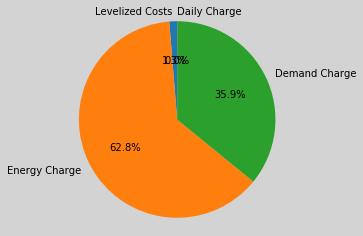

Total roof area of the  building: 3,563 m²
Total roof area used 1,136 m²
Percentage: 31.9%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 260, 185, 26, 16, 46, 0.35, 0.35, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484456.0


ERROR:ga_logger:total demand cost: 173934.3


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,022,700 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,456 per year


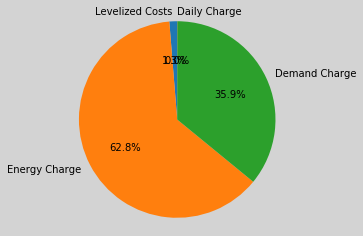

Total roof area of the  building: 3,563 m²
Total roof area used 833 m²
Percentage: 23.4%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (180, 135, 230, 36, 51, 1, 0.3, 0.3, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.024507761001587 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 1.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.972838878631592 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483403.0


ERROR:ga_logger:total demand cost: 173574.3


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,011,220 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,403 per year


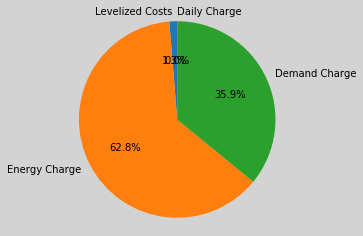

ERROR:optimizer_logger:60


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 3,563 m²
Total roof area used 2,083 m²
Percentage: 58.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (195, 140, 170, 11, 36, 1, 0.5499999999999999, 0.39999999999999997, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 11.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.841930389404297 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 1.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8407680988311768 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483975.0


ERROR:ga_logger:total demand cost: 173612.1


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,018,970 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,975 per year


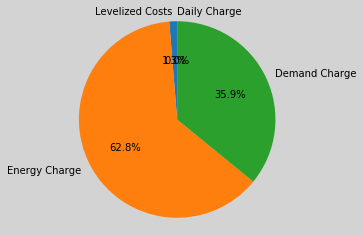

Total roof area of the  building: 3,563 m²
Total roof area used 1,136 m²
Percentage: 31.9%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (265, 165, 185, 56, 16, 36, 0.6499999999999999, 0.7499999999999998, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484246.0


ERROR:ga_logger:total demand cost: 173902.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,020,990 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,246 per year


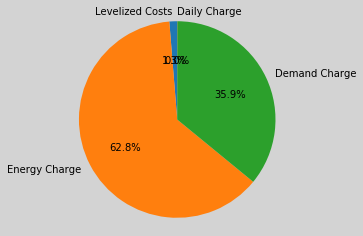

Total roof area of the  building: 3,563 m²
Total roof area used 833 m²
Percentage: 23.4%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (95, 165, 225, 11, 16, 1, 0.39999999999999997, 0.35, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 1.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.754272222518921 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484006.0


ERROR:ga_logger:total demand cost: 173871.9


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,017,550 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,006 per year


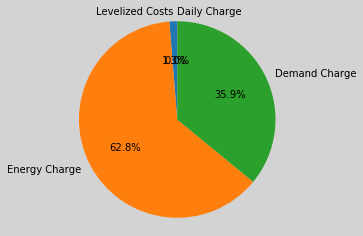

Total roof area of the  building: 3,563 m²
Total roof area used 1,786 m²
Percentage: 50.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (240, 255, 195, 36, 1, 21, 0.7999999999999998, 0.3, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 1.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6632132530212402 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.482859373092651 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 483506.0


ERROR:ga_logger:total demand cost: 173491.10000000003


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,014,930 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,506 per year


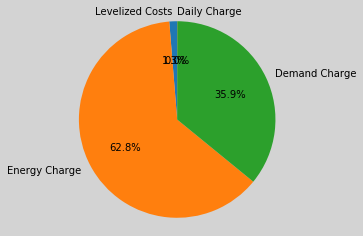

Total roof area of the  building: 3,563 m²
Total roof area used 2,500 m²
Percentage: 70.2%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (165, 215, 115, 1, 56, 16, 0.5499999999999999, 0.6499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 1.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.950209140777588 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 56.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.6144044399261475 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [480.813, 144.187, 0.0]


ERROR:ga_logger:Cost: 484771.0


ERROR:ga_logger:total demand cost: 173826.59999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,030,300 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,771 per year


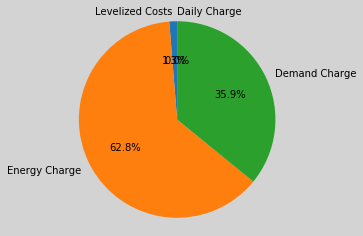

Total roof area of the  building: 3,563 m²
Total roof area used 1,096 m²
Percentage: 30.8%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (190, 230, 95, 56, 6, 26, 0.6499999999999999, 0.7499999999999998, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484466.0


ERROR:ga_logger:total demand cost: 173735.09999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,027,630 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,466 per year


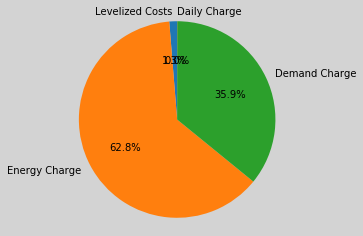

Total roof area of the  building: 3,563 m²
Total roof area used 833 m²
Percentage: 23.4%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (200, 250, 155, 51, 51, 6, 0.5499999999999999, 0.5499999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 6.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.903898000717163 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [190.469, 0.0, 434.531]


ERROR:ga_logger:Cost: 484327.0


ERROR:ga_logger:total demand cost: 173741.19999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,024,330 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,327 per year


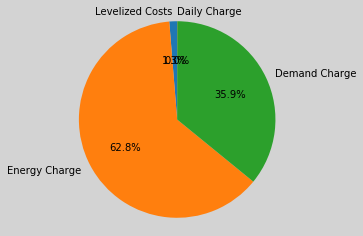

Total roof area of the  building: 3,563 m²
Total roof area used 967 m²
Percentage: 27.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (255, 240, 195, 6, 36, 56, 0.44999999999999996, 0.44999999999999996, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.941221237182617 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 56.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.5994346141815186 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [308.304, 316.696, 0.0]


ERROR:ga_logger:Cost: 484604.0


ERROR:ga_logger:total demand cost: 173739.5


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,029,040 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,604 per year


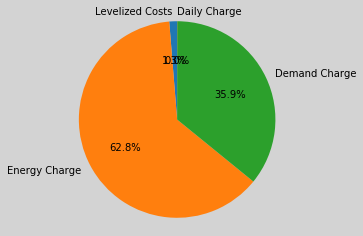

Total roof area of the  building: 3,563 m²
Total roof area used 1,389 m²
Percentage: 39.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (90, 150, 255, 36, 31, 21, 0.8499999999999999, 0.5999999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 359.768, 265.232]


ERROR:ga_logger:Cost: 484664.0


ERROR:ga_logger:total demand cost: 173928.0


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,026,370 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,664 per year


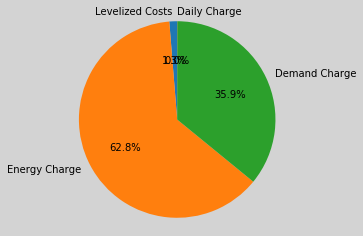

Total roof area of the  building: 3,563 m²
Total roof area used 931 m²
Percentage: 26.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (235, 130, 250, 51, 41, 46, 0.5999999999999999, 0.7499999999999998, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 485398.0


ERROR:ga_logger:total demand cost: 173885.00000000003


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,040,460 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 485,398 per year


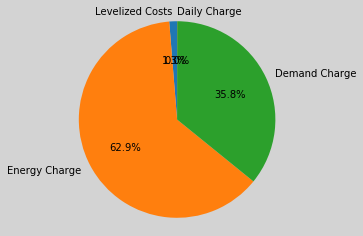

Total roof area of the  building: 3,563 m²
Total roof area used 1,042 m²
Percentage: 29.2%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (170, 215, 210, 41, 36, 36, 0.35, 0.2, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.710717439651489 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (235, 145, 100, 51, 26, 46, 0.7, 0.25, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.730732440948486 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.419928550720215 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [242.079, 382.921, 0.0]


ERROR:ga_logger:Cost: 484447.0


ERROR:ga_logger:total demand cost: 173749.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,025,770 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,447 per year


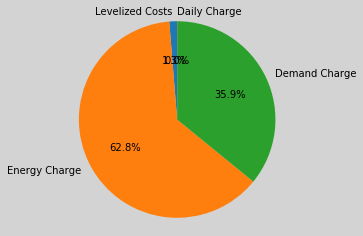

Total roof area of the  building: 3,563 m²
Total roof area used 1,878 m²
Percentage: 52.7%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (105, 195, 150, 11, 51, 1, 0.8499999999999999, 0.8999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 11.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.502462387084961 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 1.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.347299575805664 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484897.0


ERROR:ga_logger:total demand cost: 174046.90000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,028,560 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,897 per year


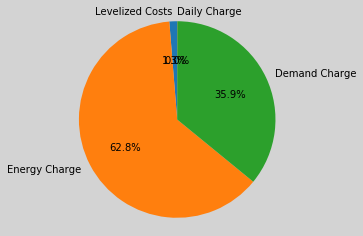

Total roof area of the  building: 3,563 m²
Total roof area used 962 m²
Percentage: 27.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (95, 245, 105, 41, 36, 16, 0.49999999999999994, 0.39999999999999997, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 314.972, 310.028]


ERROR:ga_logger:Cost: 484606.0


ERROR:ga_logger:total demand cost: 173772.29999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,029,610 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 484,606 per year


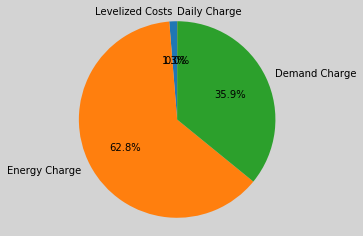

Total roof area of the  building: 3,563 m²
Total roof area used 2,028 m²
Percentage: 56.9%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (215, 210, 260, 1, 31, 56, 0.44999999999999996, 0.25, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.317345857620239 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483650.0


ERROR:ga_logger:total demand cost: 173602.89999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,017,330 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 483,650 per year


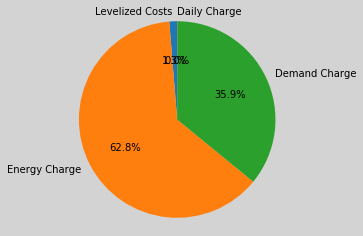

Total roof area of the  building: 3,563 m²
Total roof area used 2,500 m²
Percentage: 70.2%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (140, 145, 190, 16, 41, 41, 0.5999999999999999, 0.49999999999999994, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 16.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.133236408233643 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 41.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.190330982208252 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 483441.0


ERROR:ga_logger:total demand cost: 173582.69999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,012,100 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,441 per year


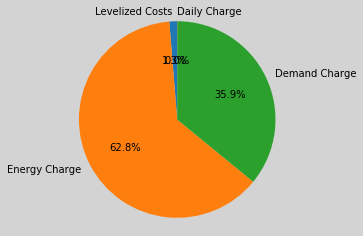

Total roof area of the  building: 3,563 m²
Total roof area used 3,125 m²
Percentage: 87.7%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (150, 175, 225, 11, 41, 41, 0.7, 0.3, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.38144588470459 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 565.097, 59.9032]


ERROR:ga_logger:Cost: 483654.0


ERROR:ga_logger:total demand cost: 173667.7


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,014,230 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,654 per year


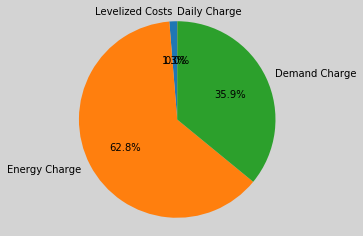

Total roof area of the  building: 3,563 m²
Total roof area used 1,976 m²
Percentage: 55.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (165, 255, 120, 56, 56, 46, 0.39999999999999997, 0.6499999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 56.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.170307397842407 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  93s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 485109.0


ERROR:ga_logger:total demand cost: 174628.90000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,022,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 485,109 per year


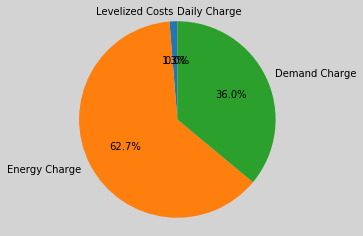

Total roof area of the  building: 3,563 m²
Total roof area used 1,562 m²
Percentage: 43.9%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (200, 120, 205, 56, 31, 41, 0.6499999999999999, 0.3, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 41.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.156576633453369 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 483723.0


ERROR:ga_logger:total demand cost: 173697.5


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,013,920 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,723 per year


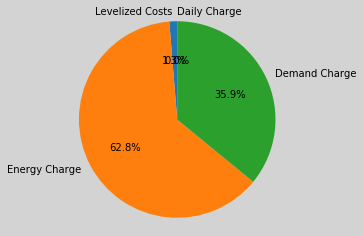

Total roof area of the  building: 3,563 m²
Total roof area used 3,125 m²
Percentage: 87.7%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (225, 200, 210, 36, 56, 31, 0.7499999999999998, 0.5499999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484061.0


ERROR:ga_logger:total demand cost: 173668.5


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,020,600 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,061 per year


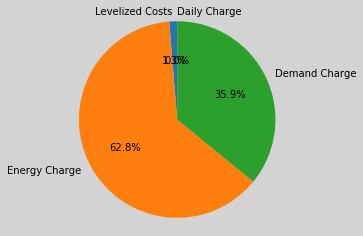

ERROR:optimizer_logger:80


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 3,563 m²
Total roof area used 962 m²
Percentage: 27.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (180, 190, 120, 21, 11, 36, 0.49999999999999994, 0.7999999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 21.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.3498406410217285 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483618.0


ERROR:ga_logger:total demand cost: 173587.1


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,015,730 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,618 per year


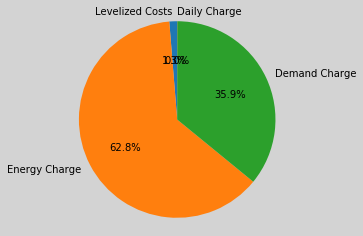

Total roof area of the  building: 3,563 m²
Total roof area used 1,250 m²
Percentage: 35.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (240, 235, 140, 46, 16, 51, 0.5999999999999999, 0.49999999999999994, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 16.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.4969165325164795 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484259.0


ERROR:ga_logger:total demand cost: 173669.90000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,023,810 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,259 per year


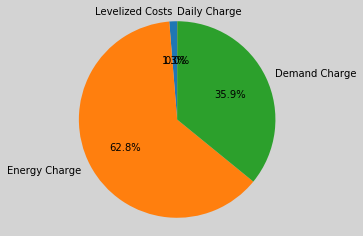

Total roof area of the  building: 3,563 m²
Total roof area used 1,250 m²
Percentage: 35.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (130, 200, 205, 51, 41, 36, 0.5999999999999999, 0.44999999999999996, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 51.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.361718416213989 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.255491495132446 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  93s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483835.0


ERROR:ga_logger:total demand cost: 173700.6


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,017,110 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,835 per year


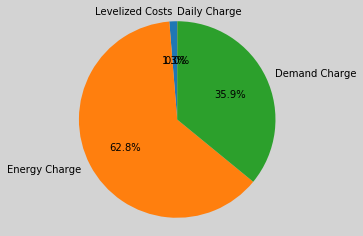

Total roof area of the  building: 3,563 m²
Total roof area used 1,389 m²
Percentage: 39.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (215, 95, 265, 11, 26, 1, 0.8499999999999999, 0.44999999999999996, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.234701633453369 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 484341.0


ERROR:ga_logger:total demand cost: 173686.6


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,025,040 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,341 per year


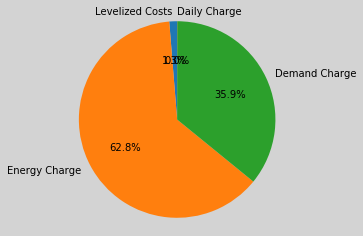

Total roof area of the  building: 3,563 m²
Total roof area used 735 m²
Percentage: 20.6%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (220, 195, 245, 31, 31, 51, 0.44999999999999996, 0.6499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  93s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483737.0


ERROR:ga_logger:total demand cost: 173559.6


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,018,190 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,737 per year


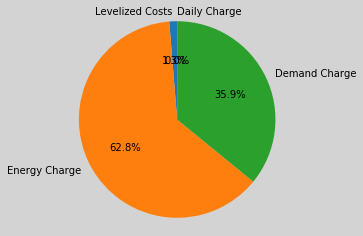

Total roof area of the  building: 3,563 m²
Total roof area used 962 m²
Percentage: 27.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (225, 180, 260, 36, 6, 16, 0.7999999999999998, 0.49999999999999994, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 6.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.5642406940460205 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 16.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.4495460987091064 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 490.146, 134.854]


ERROR:ga_logger:Cost: 484371.0


ERROR:ga_logger:total demand cost: 173731.40000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,024,480 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,371 per year


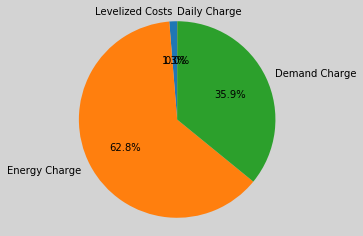

Total roof area of the  building: 3,563 m²
Total roof area used 1,520 m²
Percentage: 42.7%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (155, 190, 135, 51, 51, 36, 0.5999999999999999, 0.5999999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484362.0


ERROR:ga_logger:total demand cost: 173866.90000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,022,680 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,362 per year


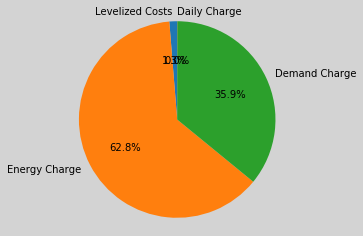

Total roof area of the  building: 3,563 m²
Total roof area used 1,042 m²
Percentage: 29.2%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (120, 180, 250, 56, 51, 31, 0.5499999999999999, 0.35, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 56.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.519240379333496 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484001.0


ERROR:ga_logger:total demand cost: 173830.69999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,017,700 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,001 per year


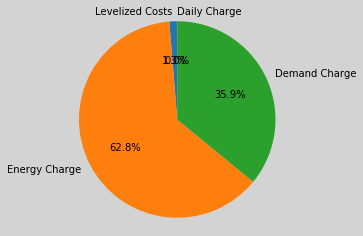

Total roof area of the  building: 3,563 m²
Total roof area used 1,786 m²
Percentage: 50.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (205, 250, 225, 26, 31, 26, 0.8499999999999999, 0.35, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 31.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2954792976379395 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 484541.0


ERROR:ga_logger:total demand cost: 173898.80000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,024,340 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,541 per year


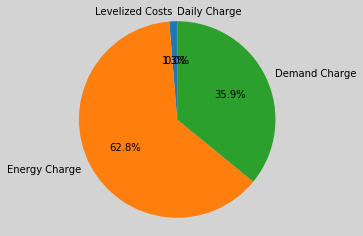

Total roof area of the  building: 3,563 m²
Total roof area used 735 m²
Percentage: 20.6%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 100, 255, 56, 31, 31, 0.7499999999999998, 0.8499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.307491779327393 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 485284.0


ERROR:ga_logger:total demand cost: 173933.7


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,036,860 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 485,284 per year


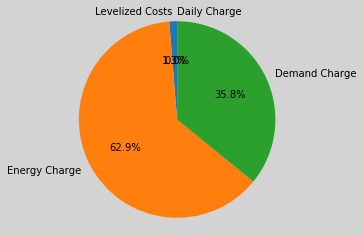

Total roof area of the  building: 3,563 m²
Total roof area used 1,042 m²
Percentage: 29.2%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (110, 260, 215, 56, 1, 11, 0.39999999999999997, 0.39999999999999997, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 56.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.151571989059448 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 1.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8810722827911377 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 11.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484088.0


ERROR:ga_logger:total demand cost: 173631.19999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,023,920 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 484,088 per year


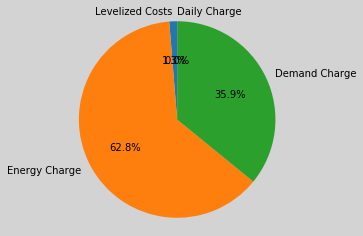

Total roof area of the  building: 3,563 m²
Total roof area used 2,083 m²
Percentage: 58.5%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 140, 215, 1, 41, 56, 0.25, 0.25, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.168739557266235 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [154.08, 209.509, 261.411]


ERROR:ga_logger:Cost: 484906.0


ERROR:ga_logger:total demand cost: 174004.80000000005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,029,500 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,906 per year


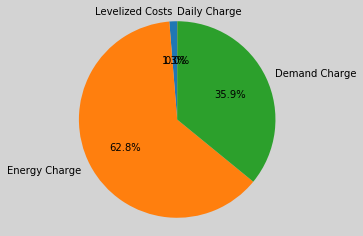

Total roof area of the  building: 3,563 m²
Total roof area used 1,803 m²
Percentage: 50.6%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (165, 185, 230, 1, 56, 26, 0.7999999999999998, 0.35, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 1.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.429746389389038 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484284.0


ERROR:ga_logger:total demand cost: 173938.30000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,020,120 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,284 per year


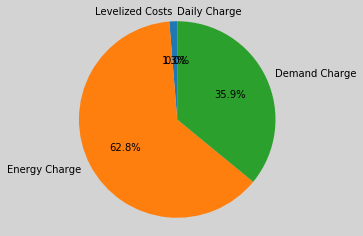

Total roof area of the  building: 3,563 m²
Total roof area used 1,786 m²
Percentage: 50.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (230, 110, 185, 56, 6, 46, 0.5499999999999999, 0.8499999999999999, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 56.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.344856262207031 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 483612.0


ERROR:ga_logger:total demand cost: 173673.30000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,012,690 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,612 per year


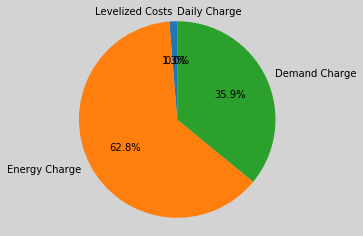

Total roof area of the  building: 3,563 m²
Total roof area used 2,500 m²
Percentage: 70.2%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (110, 100, 110, 56, 6, 21, 0.39999999999999997, 0.49999999999999994, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 485152.0


ERROR:ga_logger:total demand cost: 174327.8


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,030,270 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 485,152 per year


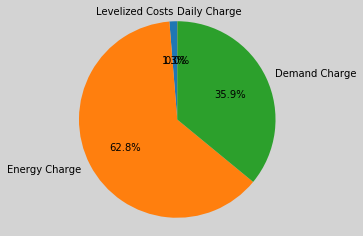

Total roof area of the  building: 3,563 m²
Total roof area used 1,250 m²
Percentage: 35.1%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (110, 185, 245, 46, 41, 36, 0.35, 0.25, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.331027269363403 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.211716413497925 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483433.0


ERROR:ga_logger:total demand cost: 173585.1


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,011,690 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,433 per year


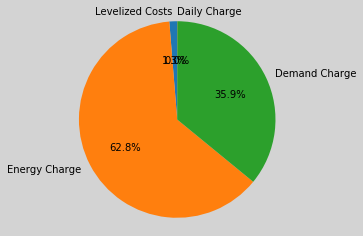

Total roof area of the  building: 3,563 m²
Total roof area used 2,500 m²
Percentage: 70.2%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (125, 175, 105, 1, 16, 21, 0.8499999999999999, 0.2, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 21.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.962636947631836 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483811.0


ERROR:ga_logger:total demand cost: 173710.80000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,017,440 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 483,811 per year


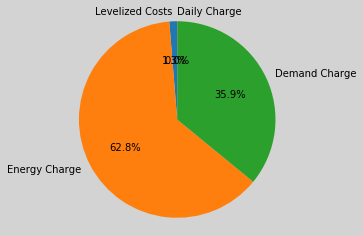

Total roof area of the  building: 3,563 m²
Total roof area used 3,125 m²
Percentage: 87.7%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (115, 100, 225, 16, 41, 51, 0.35, 0.44999999999999996, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 16.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.371826887130737 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [204.199, 0.0, 420.801]


ERROR:ga_logger:Cost: 484357.0


ERROR:ga_logger:total demand cost: 173699.9


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,025,320 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,357 per year


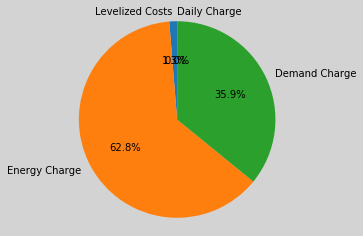

Total roof area of the  building: 3,563 m²
Total roof area used 2,267 m²
Percentage: 63.6%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (95, 245, 165, 26, 21, 56, 0.25, 0.5499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484566.0


ERROR:ga_logger:total demand cost: 173768.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,027,840 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,566 per year


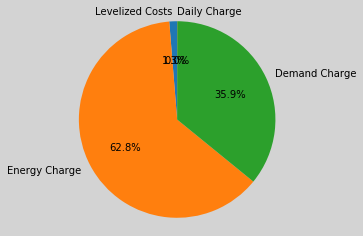

Total roof area of the  building: 3,563 m²
Total roof area used 1,136 m²
Percentage: 31.9%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (140, 155, 155, 36, 36, 26, 0.25, 0.7999999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.5197227001190186 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 484322.0


ERROR:ga_logger:total demand cost: 174188.39999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,018,130 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 484,322 per year


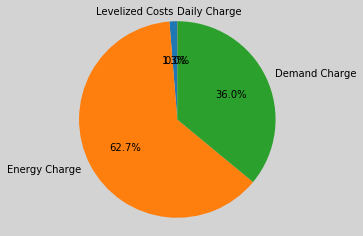

ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 3,563 m²
Total roof area used 1,136 m²
Percentage: 31.9%
19
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      170
azi1      215
azi2      210
tilt0      41
tilt1      36
tilt2      36
gcr0     0.35
gcr1      0.2
gcr2      0.7
Name: 0, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  93s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


[[170, 215, 210, 41, 36, 36, 0.35, 0.2, 0.7, 80, 0, 0.0, 0.0, 0.0, 1, 'red', [0, 0, 0], 80, 80, 0]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      180
azi1      135
azi2      230
tilt0      36
tilt1      51
tilt2       1
gcr0      0.3
gcr1      0.3
gcr2     0.35
Name: 1, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483403.0


ERROR:ga_logger:total demand cost: 173574.3


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,011,220 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,403 per year


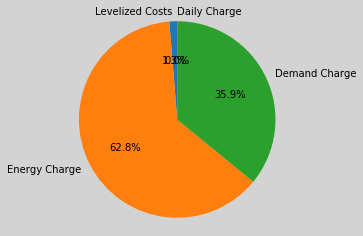

Total roof area of the  building: 3,563 m²
Total roof area used 2,083 m²
Percentage: 58.5%
[[180, 135, 230, 36, 51, 1, 0.3, 0.3, 0.35, 483403.0, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.366284699972, 'Energy Charge': 303523.76921530004, 'Demand Charge': 173574.3, 'Daily Charge': 97.5645}, 132752.0794992001, 5011220.0, 2083.33]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      245
azi1      185
azi2      145
tilt0       1
tilt1      36
tilt2      46
gcr0      0.7
gcr1     0.35
gcr2      0.6
Name: 2, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  91s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483385.0


ERROR:ga_logger:total demand cost: 173536.0


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,011,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,385 per year


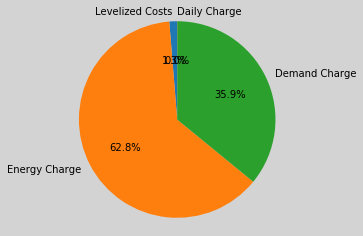

Total roof area of the  building: 3,563 m²
Total roof area used 1,786 m²
Percentage: 50.1%
[[245, 185, 145, 1, 36, 46, 0.7, 0.35, 0.5999999999999999, 483385.0, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.575065700024, 'Energy Charge': 303543.8604343, 'Demand Charge': 173536.0, 'Daily Charge': 97.5645}, 132425.12545814275, 5011400.0, 1785.71]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      110
azi1      185
azi2      245
tilt0      46
tilt1      41
tilt2      36
gcr0     0.35
gcr1     0.25
gcr2     0.25
Name: 3, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483433.0


ERROR:ga_logger:total demand cost: 173585.1


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,011,690 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,433 per year


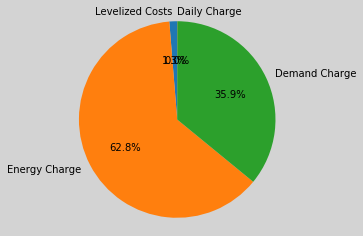

Total roof area of the  building: 3,563 m²
Total roof area used 2,500 m²
Percentage: 70.2%
[[110, 185, 245, 46, 41, 36, 0.35, 0.25, 0.25, 483433.0, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 6208.116007999932, 'Energy Charge': 303542.21949200006, 'Demand Charge': 173585.1, 'Daily Charge': 97.5645}, 132447.8218621591, 5011690.0, 2500.0]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0     140
azi1     145
azi2     190
tilt0     16
tilt1     41
tilt2     41
gcr0     0.6
gcr1     0.5
gcr2     0.2
Name: 4, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 483441.0


ERROR:ga_logger:total demand cost: 173582.69999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,012,100 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,441 per year


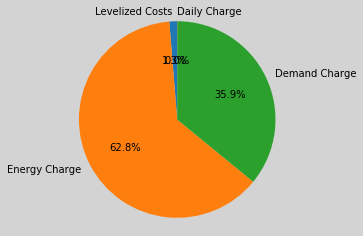

Total roof area of the  building: 3,563 m²
Total roof area used 3,125 m²
Percentage: 87.7%
[[140, 145, 190, 16, 41, 41, 0.5999999999999999, 0.4999999999999999, 0.2, 483441.0, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6208.16443615, 'Energy Charge': 303552.57106385, 'Demand Charge': 173582.69999999998, 'Daily Charge': 97.5645}, 132277.244664382, 5012100.0, 3125.0]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      175
azi1      135
azi2      100
tilt0      26
tilt1      21
tilt2      11
gcr0      0.3
gcr1     0.65
gcr2     0.45
Name: 5, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  93s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483519.0


ERROR:ga_logger:total demand cost: 173653.50000000003


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,012,300 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,519 per year


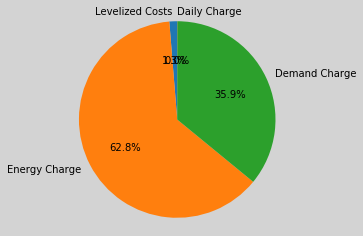

Total roof area of the  building: 3,563 m²
Total roof area used 2,083 m²
Percentage: 58.5%
[[175, 135, 100, 26, 21, 11, 0.3, 0.6499999999999999, 0.45, 483519.0, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6208.007232000011, 'Energy Charge': 303559.92826799996, 'Demand Charge': 173653.50000000003, 'Daily Charge': 97.5645}, 132156.4694388801, 5012300.0, 2083.33]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      195
azi1      245
azi2      115
tilt0      31
tilt1      21
tilt2      51
gcr0      0.4
gcr1      0.6
gcr2     0.35
Name: 6, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483445.0


ERROR:ga_logger:total demand cost: 173513.5


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,013,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,445 per year


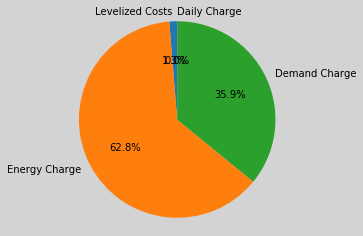

Total roof area of the  building: 3,563 m²
Total roof area used 1,562 m²
Percentage: 43.9%
[[195, 245, 115, 31, 21, 51, 0.4, 0.5999999999999999, 0.35, 483445.0, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.745919999994, 'Energy Charge': 303626.18958, 'Demand Charge': 173513.5, 'Daily Charge': 97.5645}, 131062.59365456618, 5013400.0, 1562.5]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      190
azi1      245
azi2      105
tilt0      21
tilt1      56
tilt2      31
gcr0      0.2
gcr1     0.55
gcr2     0.55
Name: 7, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483464.0


ERROR:ga_logger:total demand cost: 173483.90000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,013,340 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,464 per year


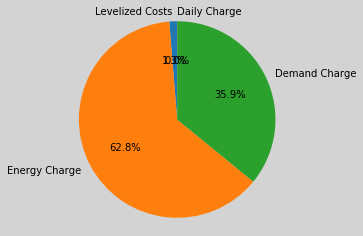

Total roof area of the  building: 3,563 m²
Total roof area used 3,125 m²
Percentage: 87.7%
[[190, 245, 105, 21, 56, 31, 0.2, 0.5499999999999999, 0.5499999999999999, 483464.0, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6208.117428799953, 'Energy Charge': 303674.4180712, 'Demand Charge': 173483.90000000002, 'Daily Charge': 97.5645}, 130268.9295134791, 5013340.0, 3125.0]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      230
azi1      110
azi2      185
tilt0      56
tilt1       6
tilt2      46
gcr0     0.55
gcr1     0.85
gcr2     0.25
Name: 8, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 483612.0


ERROR:ga_logger:total demand cost: 173673.30000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,012,690 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,612 per year


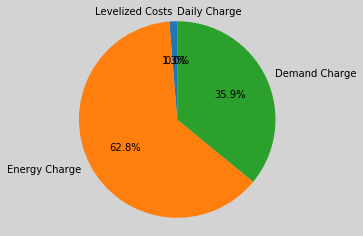

Total roof area of the  building: 3,563 m²
Total roof area used 2,500 m²
Percentage: 70.2%
[[230, 110, 185, 56, 6, 46, 0.5499999999999999, 0.8499999999999999, 0.25, 483612.0, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.702685500037, 'Energy Charge': 303633.43281449995, 'Demand Charge': 173673.30000000002, 'Daily Charge': 97.5645}, 130945.69362286411, 5012690.0, 2500.0]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      240
azi1      255
azi2      195
tilt0      36
tilt1       1
tilt2      21
gcr0      0.8
gcr1      0.3
gcr2     0.25
Name: 9, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 483506.0


ERROR:ga_logger:total demand cost: 173491.10000000003


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,014,930 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,506 per year


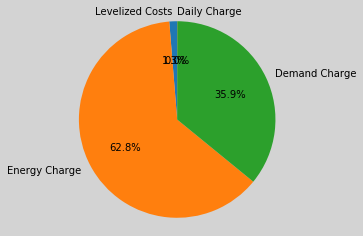

Total roof area of the  building: 3,563 m²
Total roof area used 2,500 m²
Percentage: 70.2%
[[240, 255, 195, 36, 1, 21, 0.7999999999999998, 0.3, 0.25, 483506.0, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.196844149999, 'Energy Charge': 303710.13865584997, 'Demand Charge': 173491.10000000003, 'Daily Charge': 97.5645}, 129681.01870949594, 5014930.0, 2500.0]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      200
azi1      120
azi2      205
tilt0      56
tilt1      31
tilt2      41
gcr0     0.65
gcr1      0.3
gcr2      0.2
Name: 10, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  92s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 483723.0


ERROR:ga_logger:total demand cost: 173697.5


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,013,920 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,723 per year


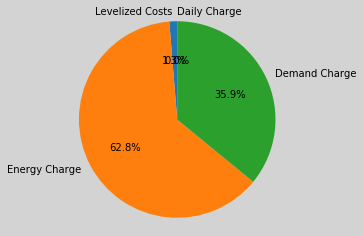

Total roof area of the  building: 3,563 m²
Total roof area used 3,125 m²
Percentage: 87.7%
[[200, 120, 205, 56, 31, 41, 0.6499999999999999, 0.3, 0.2, 483723.0, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.9316891500275, 'Energy Charge': 303720.00381085, 'Demand Charge': 173697.5, 'Daily Charge': 97.5645}, 129514.74463144319, 5013920.0, 3125.0]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0     205
azi1     165
azi2     135
tilt0     26
tilt1     31
tilt2     26
gcr0     0.3
gcr1     0.6
gcr2     0.9
Name: 11, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483549.0


ERROR:ga_logger:total demand cost: 173524.9


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,017,940 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 483,549 per year


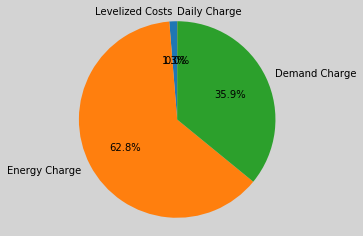

Total roof area of the  building: 3,563 m²
Total roof area used 2,083 m²
Percentage: 58.5%
[[205, 165, 135, 26, 31, 26, 0.3, 0.5999999999999999, 0.8999999999999999, 483549.0, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.590450000025, 'Energy Charge': 303718.94505, 'Demand Charge': 173524.9, 'Daily Charge': 97.5645}, 129532.83143866781, 5017940.0, 2083.33]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0     180
azi1     190
azi2     120
tilt0     21
tilt1     11
tilt2     36
gcr0     0.5
gcr1     0.8
gcr2     0.9
Name: 12, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483618.0


ERROR:ga_logger:total demand cost: 173587.1


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,015,730 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,618 per year


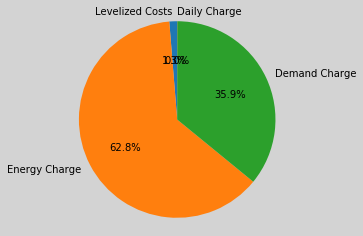

Total roof area of the  building: 3,563 m²
Total roof area used 1,250 m²
Percentage: 35.1%
[[180, 190, 120, 21, 11, 36, 0.4999999999999999, 0.7999999999999998, 0.8999999999999999, 483618.0, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.318646000007, 'Energy Charge': 303726.016854, 'Demand Charge': 173587.1, 'Daily Charge': 97.5645}, 129416.85375749996, 5015730.0, 1250.0]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      150
azi1      175
azi2      225
tilt0      11
tilt1      41
tilt2      41
gcr0      0.7
gcr1      0.3
gcr2     0.65
Name: 13, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  91s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 565.097, 59.9032]


ERROR:ga_logger:Cost: 483654.0


ERROR:ga_logger:total demand cost: 173667.7


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,014,230 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,654 per year


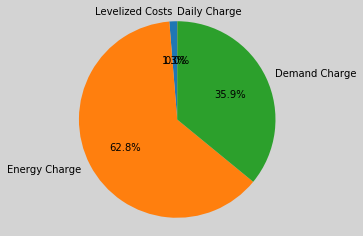

Total roof area of the  building: 3,563 m²
Total roof area used 1,976 m²
Percentage: 55.5%
[[150, 175, 225, 11, 41, 41, 0.7, 0.3, 0.6499999999999999, 483654.0, 625.0002, 0.0, 565.097, 59.9032, 1, 'blue', {'Levelized Costs': 6207.682775999921, 'Energy Charge': 303681.05272400007, 'Demand Charge': 173667.7, 'Daily Charge': 97.5645}, 130158.15184441434, 5014230.0, 1975.81]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      185
azi1      210
azi2      240
tilt0      46
tilt1       6
tilt2      11
gcr0     0.35
gcr1      0.3
gcr2     0.35
Name: 14, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 483692.0


ERROR:ga_logger:total demand cost: 173690.20000000004


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,014,480 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,692 per year


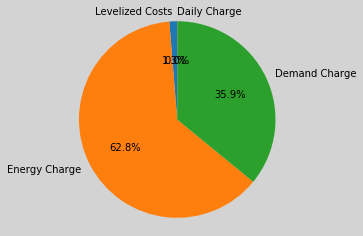

Total roof area of the  building: 3,563 m²
Total roof area used 1,786 m²
Percentage: 50.1%
[[185, 210, 240, 46, 6, 11, 0.35, 0.3, 0.35, 483692.0, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.22793614999, 'Energy Charge': 303697.00756384997, 'Demand Charge': 173690.20000000004, 'Daily Charge': 97.5645}, 129897.41777737871, 5014480.0, 1785.71]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      215
azi1      210
azi2      260
tilt0       1
tilt1      31
tilt2      56
gcr0     0.45
gcr1     0.25
gcr2      0.2
Name: 15, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483650.0


ERROR:ga_logger:total demand cost: 173602.89999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,017,330 kWh
At a cost of $ 0.0605 /kWh
Total Cost of the system: $ 483,650 per year


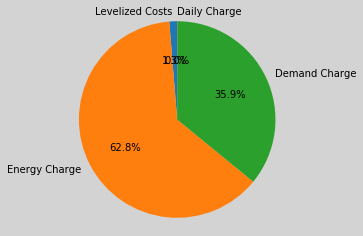

Total roof area of the  building: 3,563 m²
Total roof area used 2,500 m²
Percentage: 70.2%
[[215, 210, 260, 1, 31, 56, 0.45, 0.25, 0.2, 483650.0, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.623100000004, 'Energy Charge': 303741.91240000003, 'Demand Charge': 173602.89999999997, 'Daily Charge': 97.5645}, 129155.3211904271, 5017330.0, 2500.0]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0     245
azi1     190
azi2     105
tilt0     41
tilt1     16
tilt2     31
gcr0     0.3
gcr1     0.4
gcr2     0.9
Name: 16, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  92s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 483682.0


ERROR:ga_logger:total demand cost: 173534.7


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,017,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,682 per year


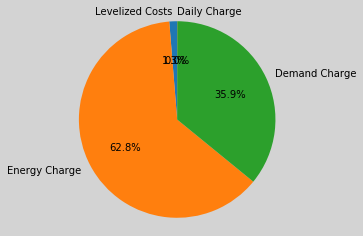

Total roof area of the  building: 3,563 m²
Total roof area used 1,562 m²
Percentage: 43.9%
[[245, 190, 105, 41, 16, 31, 0.3, 0.4, 0.8999999999999999, 483682.0, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.966934149947, 'Energy Charge': 303841.76856585004, 'Demand Charge': 173534.7, 'Daily Charge': 97.5645}, 127504.47759831778, 5017400.0, 1562.5]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      100
azi1      160
azi2      260
tilt0       6
tilt1      31
tilt2      41
gcr0      0.6
gcr1      0.5
gcr2     0.75
Name: 17, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  92s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 484180.0


ERROR:ga_logger:total demand cost: 174136.69999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,015,710 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 484,180 per year


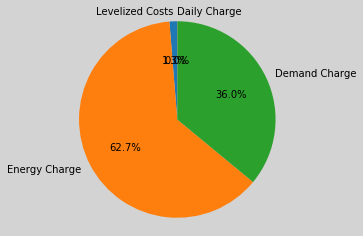

Total roof area of the  building: 3,563 m²
Total roof area used 1,250 m²
Percentage: 35.1%
[[100, 160, 260, 6, 31, 41, 0.5999999999999999, 0.4999999999999999, 0.7499999999999998, 484180.0, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 6208.106427120052, 'Energy Charge': 303737.62907287996, 'Demand Charge': 174136.69999999998, 'Daily Charge': 97.5645}, 129223.43276189982, 5015710.0, 1250.0]]
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0      220
azi1      220
azi2      215
tilt0      11
tilt1      46
tilt2      36
gcr0     0.55
gcr1     0.75
gcr2     0.25
Name: 18, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 483833.0


ERROR:ga_logger:total demand cost: 173687.0


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,016,850 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 483,833 per year


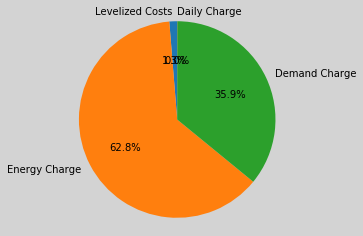

Total roof area of the  building: 3,563 m²
Total roof area used 2,500 m²
Percentage: 70.2%
[[220, 220, 215, 11, 46, 36, 0.5499999999999999, 0.7499999999999998, 0.25, 483833.0, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6208.2770014999915, 'Energy Charge': 303840.1584985, 'Demand Charge': 173687.0, 'Daily Charge': 97.5645}, 127532.46449712302, 5016850.0, 2500.0]]


In [25]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_file,
                 ehub_file=ehub_file,
                 res_file=res_file,
                 pvbuilding=pvbuilding,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","DUAL")
pvoptimizer.processGA(ga_proc)